In [ ]:
%pip install -q requests pyjwt werkzeug openseries ipython nbformat

In [2]:
import datetime as dt

import plotly.io as pio
from openseries import OpenFrame, OpenTimeSeries, load_plotly_dict, report_html

from graphql_client import GraphqlClient, GraphqlError

In [3]:
pio.renderers.default = "vscode"  # notebook_connected, colab, vscode
figdict, _ = load_plotly_dict()

In [5]:
gql = GraphqlClient()

In [6]:
def get_timeseries(
    graphql: GraphqlClient,
    timeseries_ids: str | list[str] | None = None,
    instrument_ids: str | list[str] | None = None,
    names: str | list[str] | None = None,
    isin_codes: str | list[str] | None = None,
    replacing_labels: str | list[str] | None = None,
    start: dt.date | None = None,
    end: dt.date | None = None,
) -> OpenTimeSeries | OpenFrame:
    """Queries one or several timeseries."""
    query = """ query timeseries(
                   $timeseries_ids: [GraphQLObjectId!],
                   $instrument_ids: [GraphQLObjectId!],
                   $names: [String!],
                   $isin_codes: [GraphQLIsin!],
                   $valuetype: [String!] = "Price(Close)",
                   $start: GraphQLDateString,
                   $end: GraphQLDateString
                   ) {
                   timeseries(
                       filter: {
                         idIn: $timeseries_ids,
                         instrumentIdIn: $instrument_ids,
                         instrumentNameIn: $names,
                         instrumentIsinIn: $isin_codes,
                         typeIn: $valuetype,
                         startDate: $start,
                         endDate: $end,
                         statusIn: Active
                       }
                       includeItems: true
                   ) {
                       _id
                       type
                       instrument {
                         _id
                         name
                         currency
                         isin
                       }
                       dates
                       values
                   }
                } """
    variables = {
        "timeseries_ids": list(timeseries_ids) if timeseries_ids else None,
        "instrument_ids": list(instrument_ids) if instrument_ids else None,
        "names": list(names) if names else None,
        "isin_codes": list(isin_codes) if isin_codes else None,
        "start": start.strftime("%Y-%m-%d") if start else None,
        "end": end.strftime("%Y-%m-%d") if end else None,
    }

    data, errors = graphql.query(query_string=query, variables=variables)

    if errors:
        raise GraphqlError(str(errors))

    output: list[OpenTimeSeries] = []

    for i, series in enumerate(data["timeseries"]):
        if replacing_labels:
            if len(data["timeseries"]) != len(replacing_labels):
                msg = "Number of labels mush match number of timeseries."
                raise ValueError(msg)
            label = replacing_labels[i]
        else:
            label = series["instrument"]["name"]
        output.append(
            OpenTimeSeries.from_arrays(
                name=label,
                timeseries_id=series["_id"],
                instrument_id=series["instrument"]["_id"],
                isin=series["instrument"]["isin"],
                baseccy=series["instrument"]["currency"],
                dates=series["dates"],
                values=series["values"],
            )
        )

    if len(output) == 1:
        return output[0]
    return OpenFrame(constituents=output)

In [7]:
start = dt.date(2017, 5, 29)
end = None

myseries = get_timeseries(
    graphql=gql,
    start=start,
    end=end,
    names=["CAPIRISC", "SEK Swap Basket TR"],
    replacing_labels=["Captor Iris Bond C", "Iris Bond internal benchmark"],
)

In [8]:
_ = myseries.to_xlsx(filename="data.xlsx")

_ = myseries.to_cumret()

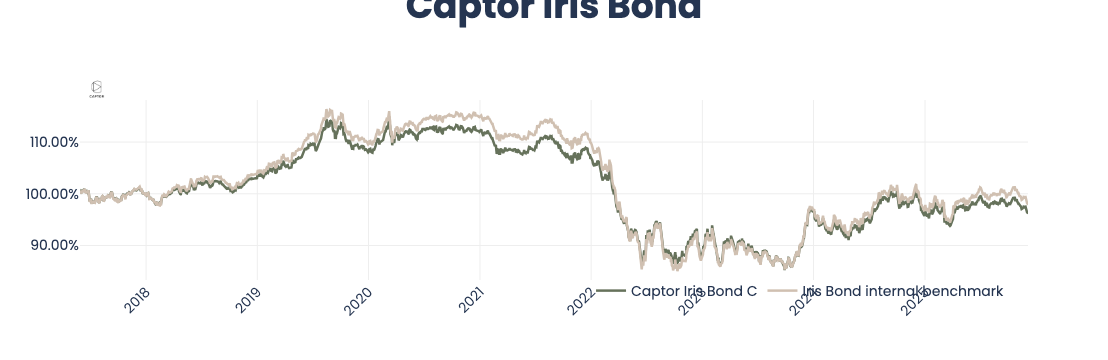

In [9]:
figure, _ = myseries.plot_series(
    tick_fmt=".2%", output_type="div", title="Captor Iris Bond"
)
figure.show(config=figdict["config"])

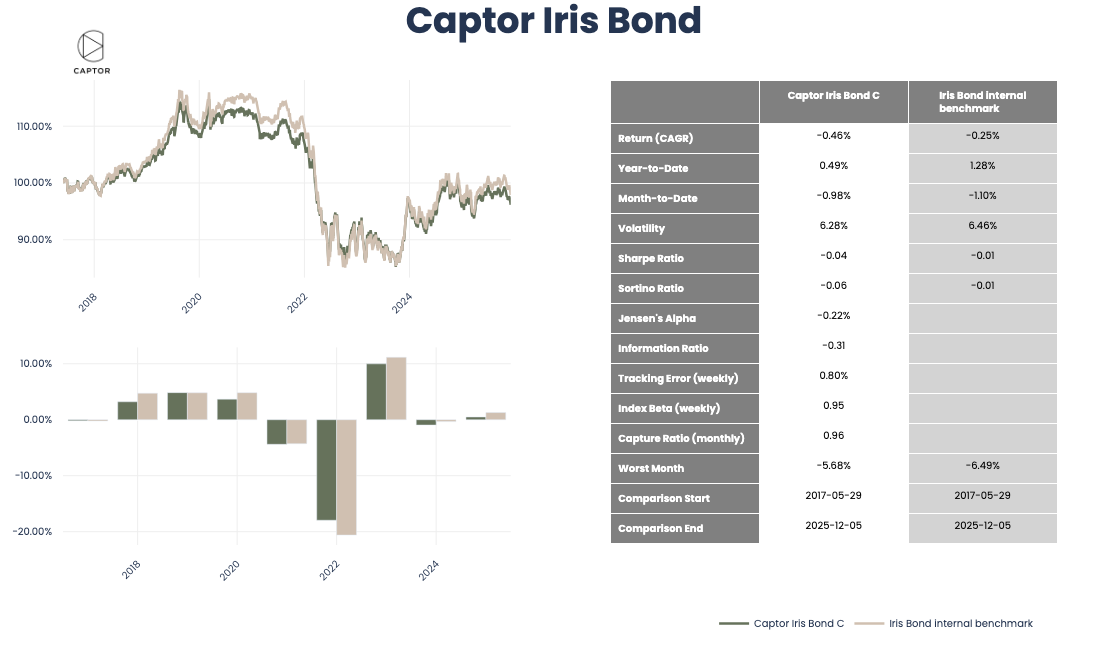

In [10]:
report, _ = report_html(
    data=myseries,
    title="Captor Iris Bond",
    bar_freq="BYE",
    vertical_legend=False,
    output_type="div",
)
report = report.update_layout(font_size=10, width=1100, height=650)
report.show(config=figdict["config"])